<a href="https://colab.research.google.com/github/romanbash/DTSA-5511-Cancer-Detection/blob/main/Histopathologic_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***DTSA-5511: Week 3 - Histopathologic Cancer Detection***

## Github: https://github.com/romanbash/DTSA-5511-Cancer-Detection


## Part 1: Brief Description of the Problem and Data

This project must identify metastatic cancer from larger digital pathology scans in small image patches.
In this project, we will build a convolution neuron network and perform a binary classification of the pictures in the data set.

The data consists of RGB images in TIF format. The training label is assigned as positive if at least one pixel in the image contains tumorous tissue. This dataset is a file labeling this data, which is present in CSV format. The total size of the download from Kaggle is 7.76GB.

First, Let's import all the packages we would use in our project.

In [1]:
import os
from PIL import Image
from google.colab import drive
import pickle
import hashlib
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4  # Example using EfficientNetB4


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's check if the GPU works.

In [2]:
# Check for GPU availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

# Specify the GPU device to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Enable GPU acceleration
tf.keras.backend.set_image_data_format('channels_last')
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

GPU is not available


This hack if for quicker IO of pictures. We unzip all the data to "/content".

In [3]:
!unzip -q "/content/drive/MyDrive/DTSA 5511/Week 3/histopathologic-cancer-detection.zip" -d "/content"

# Exploratory Data Analysis

In [4]:
train_dir = "/content/train"
num_files = len([f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))])

print(f"Number of files in the train directory: {num_files}")


Number of files in the train directory: 220025


In [5]:
test_dir = "/content/test"
num_files = len([f for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))])

print(f"Number of files in the train directory: {num_files}")

Number of files in the train directory: 57458


In [6]:
train_labels_path = "/content/drive/MyDrive/DTSA 5511/Week 3/train_labels.csv"
df = pd.read_csv(train_labels_path)

num_rows = len(df)
print(f"Number of rows in train_labels.csv: {num_rows}")


Number of rows in train_labels.csv: 220025


The number of rows match the number of pictures.

In [7]:
full_train_df = pd.read_csv(train_labels_path)

Let's load our Dataframe to drive for quicker star of work.

In [8]:
# Define the path to save the pickle file in your Google Drive
pickle_file_path = '/content/drive/MyDrive/DTSA 5511/Week 3/full_train_df.pickle'

# Save the DataFrame to a pickle file
#with open(pickle_file_path, 'wb') as f:
#  pickle.dump(full_train_df, f)

# Load the DataFrame from the pickle file
with open(pickle_file_path, 'rb') as f:
  full_train_df = pickle.load(f)

# Print some info to verify it loaded correctly
print(full_train_df.head())
print(f"Shape of loaded DataFrame: {full_train_df.shape}")


                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Shape of loaded DataFrame: (220025, 2)


In [9]:
full_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


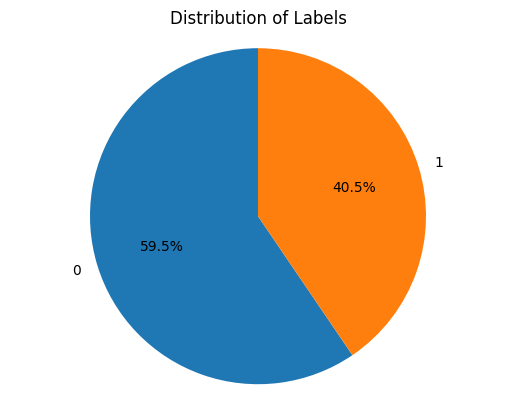

In [10]:
# Count the number of instances of each label
label_counts = full_train_df['label'].value_counts()

# Create a pie chart
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Labels')
plt.show()


So, the data is not perfectly balanced, but we have enough data for each label.

Let's check for duplicates in the files (we use a hash function to look for similar images) and file names in the CSV.

In [11]:
def find_duplicate_files(directory):
  """Finds duplicate files in a directory based on their content."""
  hashes = {}
  duplicates = []

  for dirpath, _, filenames in os.walk(directory):
    for filename in filenames:
      filepath = os.path.join(dirpath, filename)
      try:
        with open(filepath, 'rb') as f:
          file_hash = hashlib.md5(f.read()).hexdigest()
      except Exception as e:
        print(f"Error processing file {filepath}: {e}")
        continue

      if file_hash in hashes:
        duplicates.append((filepath, hashes[file_hash]))
      else:
        hashes[file_hash] = filepath

  return duplicates


def find_duplicate_rows_df(df, column_name):
  """Finds duplicate rows in a DataFrame based on a specific column."""
  duplicate_rows = df[df.duplicated(subset=[column_name], keep=False)]
  return duplicate_rows


# Find duplicate files in the train directory
duplicate_files = find_duplicate_files(train_dir)

if duplicate_files:
  print("Duplicate files found:")
  for file1, file2 in duplicate_files:
    print(f"- {file1} and {file2}")
else:
  print("No duplicate files found in the train directory.")


# Find duplicate rows in the DataFrame based on the 'id' column
duplicate_rows_df = find_duplicate_rows_df(df, 'id')

if not duplicate_rows_df.empty:
  print("\nDuplicate rows found in the DataFrame:")
  print(duplicate_rows_df)
else:
  print("\nNo duplicate rows found in the DataFrame.")

No duplicate files found in the train directory.

No duplicate rows found in the DataFrame.


Looks great. Now let's look at some pictures.

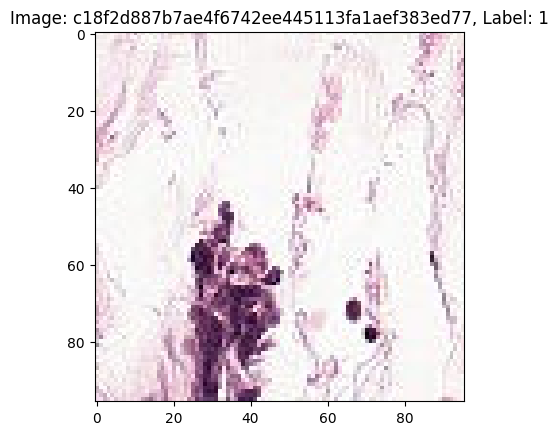

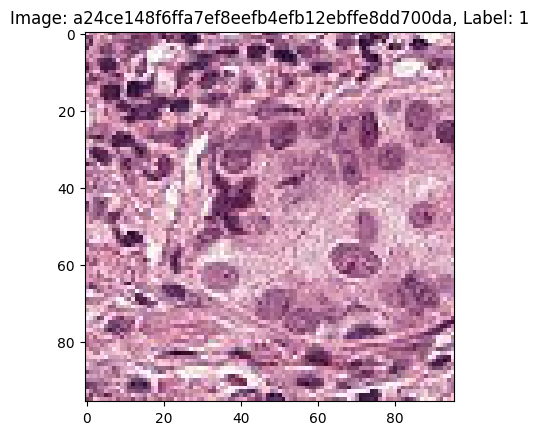

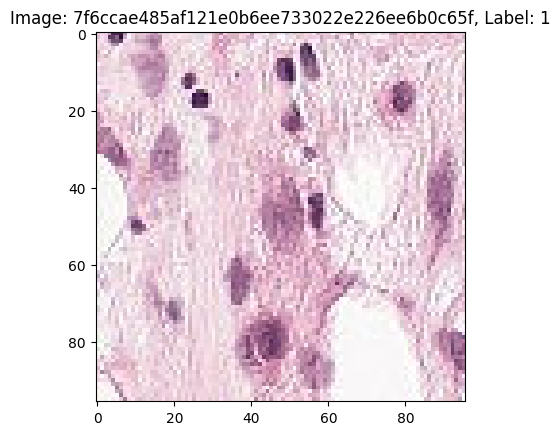

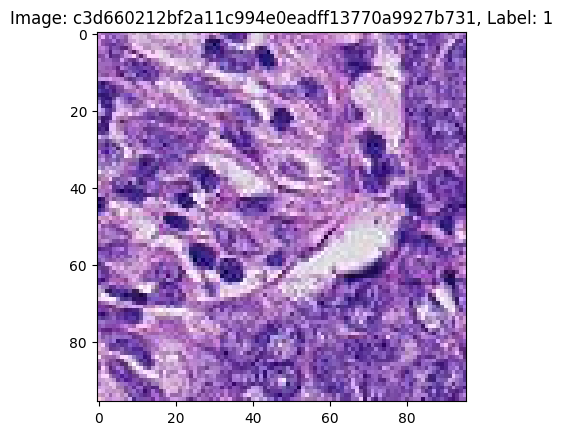

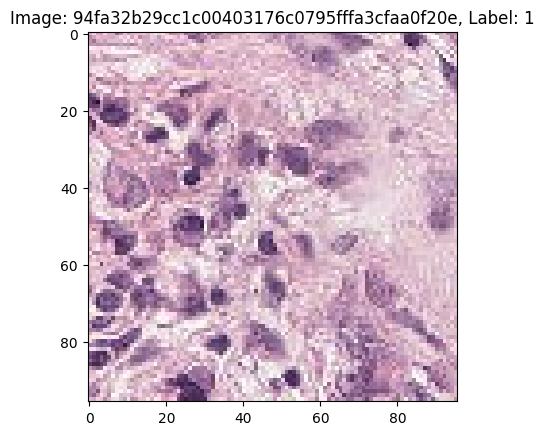

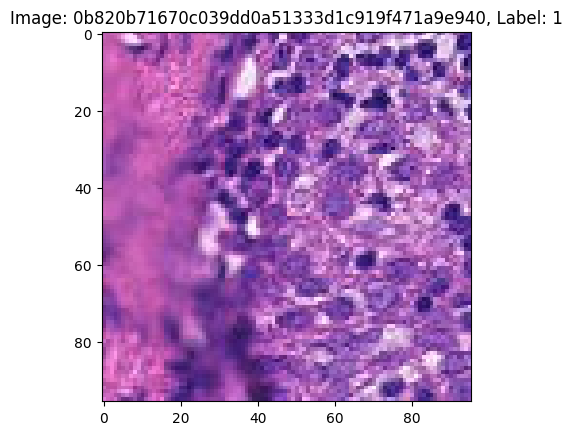

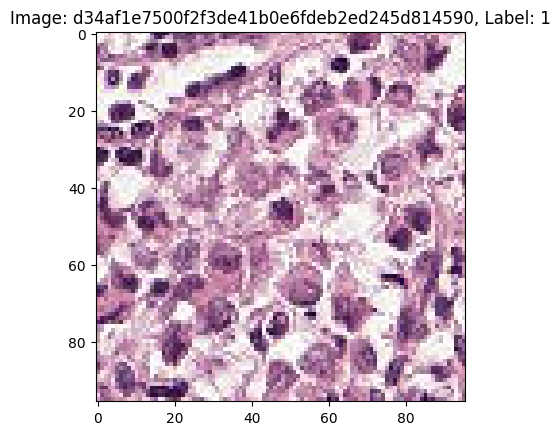

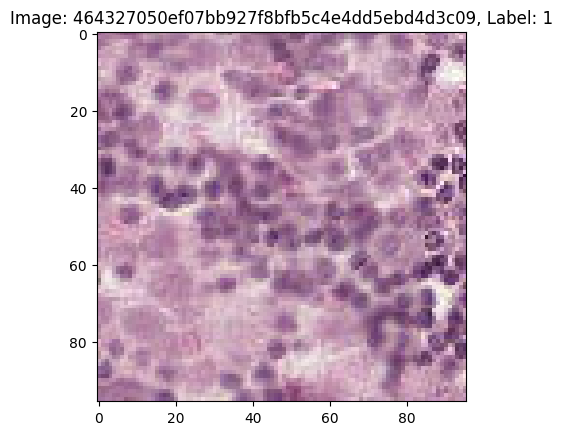

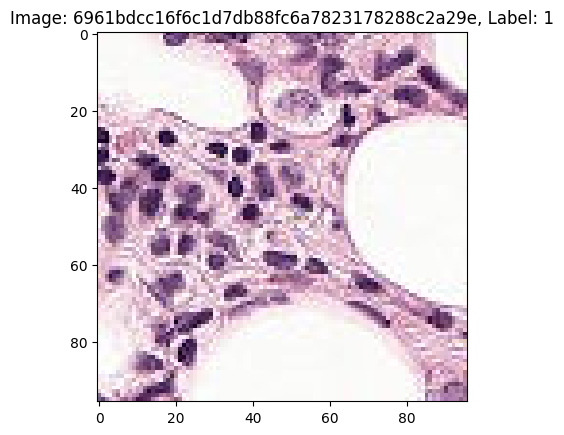

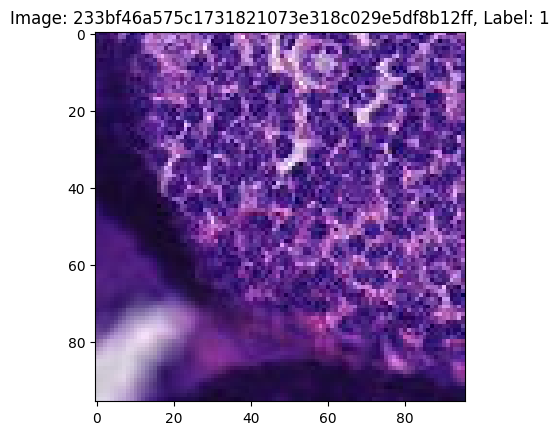

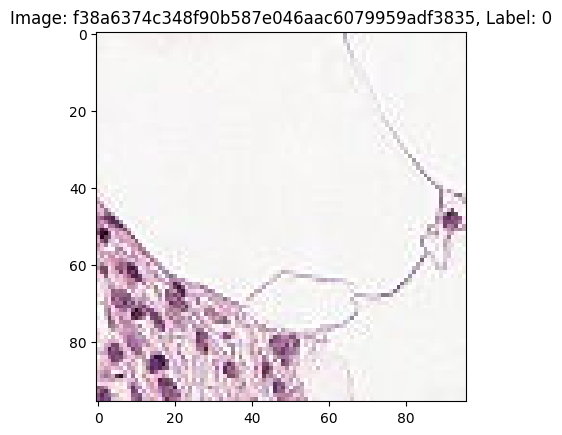

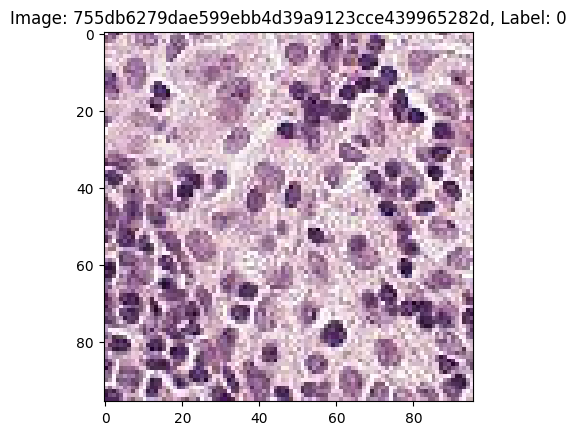

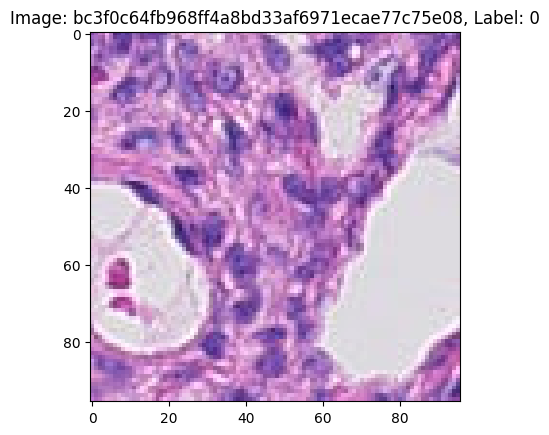

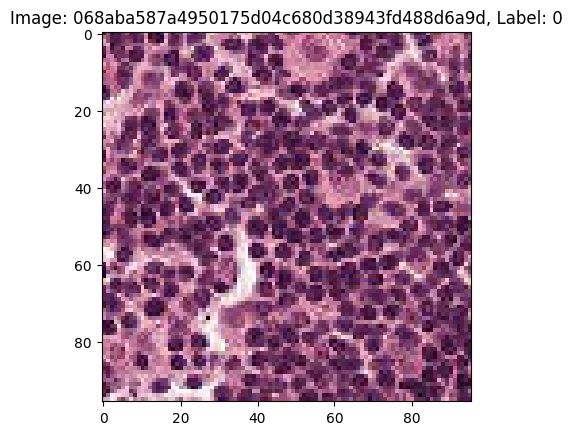

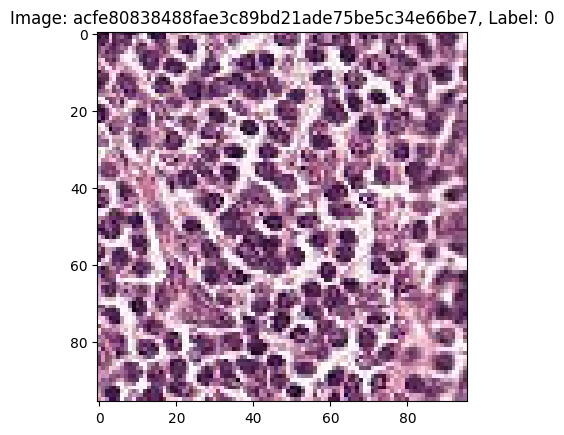

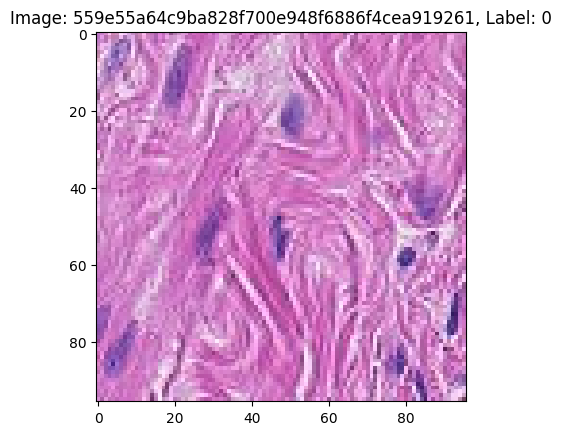

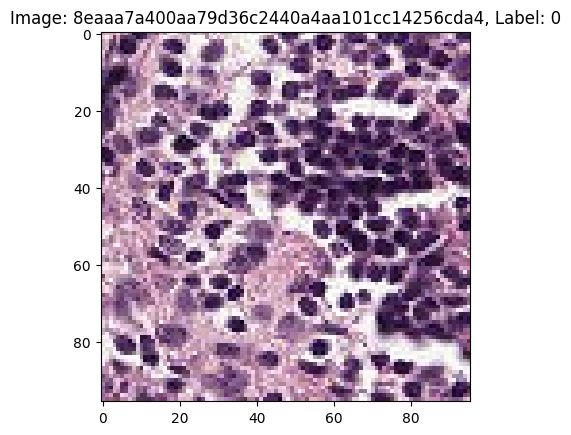

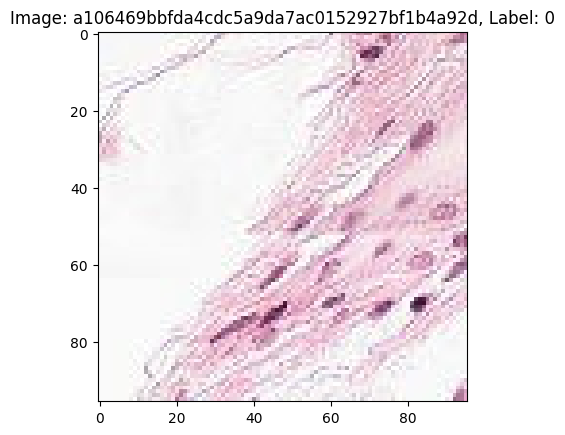

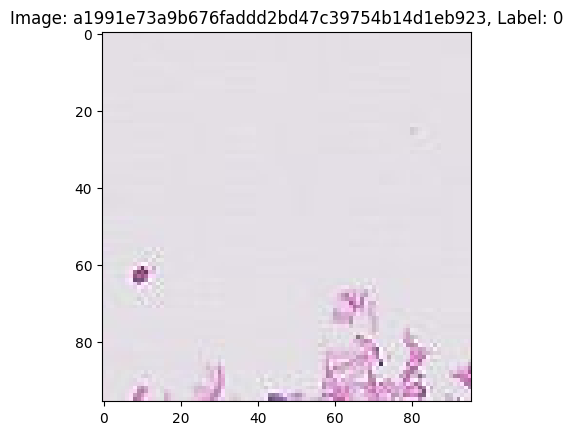

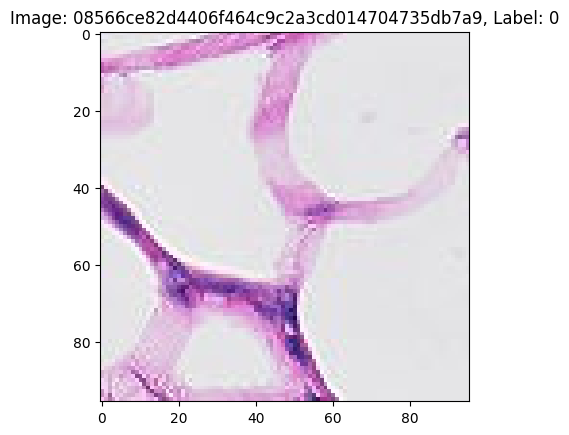

In [ ]:
# Get 10 images with label 1
label_1_df = full_train_df[full_train_df['label'] == 1].head(10)
for index, row in label_1_df.iterrows():
  image_path = os.path.join("/content/train", row['id'] + ".tif")
  try:
    img = Image.open(image_path)
    plt.imshow(np.array(img))
    plt.title(f"Image: {row['id']}, Label: {row['label']}")
    plt.show()
  except FileNotFoundError:
    print(f"Image not found: {image_path}")


# Get 10 images with label 0
label_0_df = full_train_df[full_train_df['label'] == 0].head(10)
for index, row in label_0_df.iterrows():
  image_path = os.path.join("/content/train", row['id'] + ".tif")
  try:
    img = Image.open(image_path)
    plt.imshow(np.array(img))
    plt.title(f"Image: {row['id']}, Label: {row['label']}")
    plt.show()
  except FileNotFoundError:
    print(f"Image not found: {image_path}")


There is no difference between cancer and non-cancer cells that can be spotted with the eye. Let's start training and see if CNN can do better work.

In [7]:
train_df, val_df = train_test_split(full_train_df, test_size=0.2, stratify=full_train_df['label'], random_state=42)

# Print the shapes of the new DataFrames
print("Training DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", val_df.shape)

Training DataFrame shape: (176020, 2)
Validation DataFrame shape: (44005, 2)


# The model

In this section, we will try three different models: a basic CNN, an advanced CNN with more layers, dropout, and data augmentation. The third part would take a pre-trained model and fine-tune it to fit the task. We will also try different learning rates, data augmentation, and preprocessing techniques to see how these techniques influence the results.

**Why we use this layers?**

*Convolutional Layers* -  These layers are the core building blocks of a CNN. They apply a set of learnable filters to the input image to extract features.

*Max Pooling Layers*: These layers reduce the spatial dimensions of the feature maps output by the convolutional layers.

*Dropout Layers*: These layers randomly deactivate a fraction of the neurons during training. * Overfitting Prevention:

Let's see our image size.

In [8]:
train_dir = "/content//train"

# Choose a sample image
image_path = os.path.join(train_dir, os.listdir(train_dir)[0])

# Open the image using PIL
img = Image.open(image_path)

# Get the width and height of the image
width, height = img.size

print(f"Image pixel size: {width}x{height}")
train_df


Image pixel size: 96x96


,id,label
198607,cffe7a3ffc48700045fd37f1f448b5a892ff4f2c,0
14684,b5bef3e7d7e8cc81e38fa2288105fc1c130e771a,0
55923,6fe4413a3a982af28a6e78d0f445073c509b4b33,0
215817,d6b4fe580210f5ea61b7c109b5c2e5cc734c3010,0
10219,1b6b051e370ca8468253d2e40f686c66eecb1619,1
...,...,...
166899,cd89a0b5419c27ab46e9dc904cbd7b36433f1536,0
21226,70ca5eeee14bc879e1e60aa891bfaf7a12b75719,0
17268,ebe8012d370e5b3a4acbefa4fbfbf96bc5bbe00c,0
198379,07b42f37c6a5dd57161ca1a4a911af8571762775,1


Let's check if all the pics in train directory are the the same size - 96*96


In [12]:
incorrect_size_count = 0

for filename in os.listdir(train_dir):
  if filename.endswith(".tif"):
    image_path = os.path.join(train_dir, filename)
    try:
      img = Image.open(image_path)
      width, height = img.size
      if width != 96 or height != 96:
        incorrect_size_count += 1
        print(f"Image {filename} has incorrect size: {width}x{height}")
    except Exception as e:
      print(f"Error processing image {filename}: {e}")

if incorrect_size_count == 0:
  print("All images in the train directory have the correct size (96x96).")
else:
  print(f"{incorrect_size_count} images in the train directory have incorrect size.")

All images in the train directory have the correct size (96x96).


Let's try a basic CNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_basic_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

basic_model = create_basic_model()
basic_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Convert labels to strings
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# Create a new 'filename' column by adding '.tif' extension
train_df['filename'] = train_df['id'] + '.tif'
val_df['filename'] = val_df['id'] + '.tif'

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',  # Use the new 'filename' column
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='filename',  # Use the new 'filename' column
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_basic_model = basic_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 498s 89ms/step - accuracy: 0.7738 - loss: 0.4810 - val_accuracy: 0.8122 - val_loss: 0.4250
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 377s 69ms/step - accuracy: 0.8363 - loss: 0.3802 - val_accuracy: 0.8316 - val_loss: 0.3845
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 335s 60ms/step - accuracy: 0.8512 - loss: 0.3464 - val_accuracy: 0.8592 - val_loss: 0.3349
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 350s 63ms/step - accuracy: 0.8607 - loss: 0.3257 - val_accuracy: 0.8673 - val_loss: 0.3077
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 400s 67ms/step - accuracy: 0.8663 - loss: 0.3127 - val_accuracy: 0.8570 - val_loss: 0.3298


In [ ]:
basic_model.save('/content/drive/MyDrive/DTSA 5511/Week 3/basic_model.keras')

Advanced model

In [ ]:
with open('/content/drive/MyDrive/DTSA 5511/Week 3/basic_model_history', 'wb') as file_pi:
    pickle.dump(history_basic_model, file_pi)

In [13]:
with open('/content/drive/MyDrive/DTSA 5511/Week 3/basic_model_history', "rb") as file_pi:
    history_basic_model = pickle.load(file_pi)

Now let's train our advanced model.

In [ ]:
def create_advanced_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

advanced_model = create_advanced_model()
advanced_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
advanced_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_advanced = advanced_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 369s 65ms/step - accuracy: 0.7805 - loss: 0.4730 - val_accuracy: 0.8481 - val_loss: 0.3567
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 367s 67ms/step - accuracy: 0.8498 - loss: 0.3520 - val_accuracy: 0.8763 - val_loss: 0.2979
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 362s 63ms/step - accuracy: 0.8639 - loss: 0.3227 - val_accuracy: 0.8801 - val_loss: 0.3046
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 411s 68ms/step - accuracy: 0.8747 - loss: 0.2998 - val_accuracy: 0.8981 - val_loss: 0.2584
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 374s 67ms/step - accuracy: 0.8821 - loss: 0.2877 - val_accuracy: 0.8984 - val_loss: 0.2556


In [ ]:
advanced_model.save('/content/drive/MyDrive/DTSA 5511/Week 3/advanced_model.keras')

In [ ]:
with open('/content/drive/MyDrive/DTSA 5511/Week 3/advanced_model_history', 'wb') as file_pi:
    pickle.dump(history_advanced, file_pi)


In [14]:
with open('/content/drive/MyDrive/DTSA 5511/Week 3/advanced_model_history', "rb") as file_pi:
    history_advanced = pickle.load(file_pi)

In [9]:
advanced_model = keras.models.load_model('/content/drive/MyDrive/DTSA 5511/Week 3/advanced_model.keras')

And the last one - let's try to fine-tune a SOTA model.

In [10]:
# Freeze the base model layers:

base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

for layer in base_model.layers:
    layer.trainable = False


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Add a custom classification head

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Add a dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model using the data generator
history = model.fit(train_generator, epochs=5)  # Adjust epochs as needed

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 509s 83ms/step - accuracy: 0.5936 - loss: 0.6760
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 404s 71ms/step - accuracy: 0.5947 - loss: 0.6615
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 340s 62ms/step - accuracy: 0.5935 - loss: 0.6569
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 368s 59ms/step - accuracy: 0.5948 - loss: 0.6532
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 335s 61ms/step - accuracy: 0.5957 - loss: 0.6527


In [ ]:
for layer in base_model.layers[-10:]:  # Example: unfreeze the last 10 layers
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=10)  # Adjust epochs as needed

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 458s 74ms/step - accuracy: 0.5925 - loss: 0.6645
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 401s 71ms/step - accuracy: 0.5993 - loss: 0.6517
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 368s 67ms/step - accuracy: 0.6062 - loss: 0.6495
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 377s 66ms/step - accuracy: 0.6099 - loss: 0.6474
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 406s 74ms/step - accuracy: 0.6180 - loss: 0.6422
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 403s 73ms/step - accuracy: 0.6239 - loss: 0.6402
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 410s 67ms/step - accuracy: 0.6264 - loss: 0.6373
Epoch 8/10
5036/5501 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - accuracy: 0.6337 - loss: 0.6327

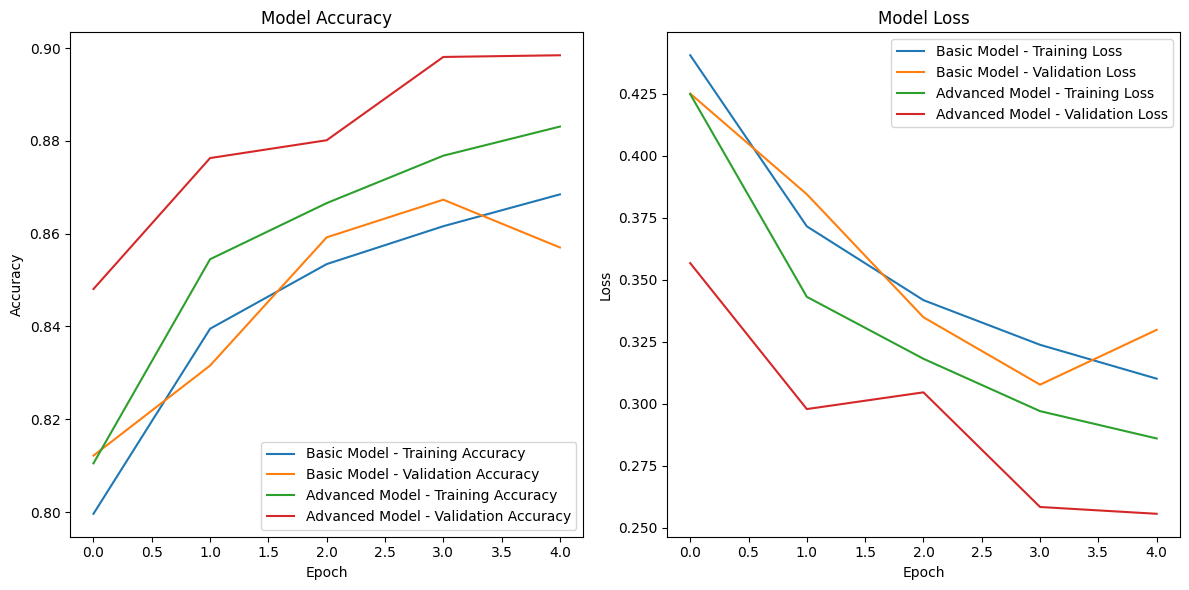

In [25]:
plt.figure(figsize=(12, 6))

# Plot accuracy for both models
plt.subplot(1, 2, 1)
plt.plot(history_basic_model['accuracy'], label='Basic Model - Training Accuracy')
plt.plot(history_basic_model['val_accuracy'], label='Basic Model - Validation Accuracy')
plt.plot(history_advanced.history['accuracy'], label='Advanced Model - Training Accuracy')
plt.plot(history_advanced.history['val_accuracy'], label='Advanced Model - Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot loss for both models
plt.subplot(1, 2, 2)
plt.plot(history_basic_model['loss'], label='Basic Model - Training Loss')
plt.plot(history_basic_model['val_loss'], label='Basic Model - Validation Loss')
plt.plot(history_advanced.history['loss'], label='Advanced Model - Training Loss')
plt.plot(history_advanced.history['val_loss'], label='Advanced Model - Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Results and Analysis

As we can see, the advanced model gave us better results. The loss values are smaller in both - training and validation. The accuracy is better, especially in the training and validation. The graph shows a big difference between the training and validation accuracy, which may point to overfitting. However, the two losses and accuracies are almost the same compared to the basic model. But even if the advanced model is slightly overfitting, the results of this model are much better - in the validation set and the Kaggle test set, so this is the model we should use. The third model - a finetuning of the EfficientNetB4 model gave the worst results in the training, validation, and test sets. We tried to take a pre-trained model and finetune it for our purpose. Although it is a SOTA model with many more parameters, it is not the best option for our mission.

Now let's compare the two models:

**Basic Model:**

*Architecture*: It's a simple CNN with two convolutional layers, two max-pooling layers, and two dense layers.
*Complexity*: It has fewer layers and parameters, making it relatively less complex.
*Capacity*: It has a lower capacity to learn complex patterns in the data.

**Advanced Model:**

*Architecture*: It has three convolutional layers, three max-pooling layers, and three dense layers. It also includes dropout layers.
*Complexity*: It's more complex with more layers and parameters.
*Capacity*: It has a higher capacity to learn complex patterns in the data due to its increased depth and dropout regularization.
Dropout Layers: Dropout helps prevent overfitting by randomly deactivating neurons during training. This forces the network to learn
more robust features.

**So why the Advanced Model is Better?**

*Feature Extraction*: The additional convolutional layers in the advanced model allow it to extract more complex and hierarchical features from the images. This is crucial for identifying subtle patterns associated with cancer cells.
Overfitting Prevention: Dropout layers in the advanced model help to prevent overfitting, which can occur when a model memorizes the training data too well and performs poorly on unseen data.
*Increased Capacity*: The increased depth and number of parameters in the advanced model give it a higher capacity to learn the complex relationships between image features and cancer presence.
In the context of cancer classification from pictures, the advanced model's ability to extract more complex features and its resistance to overfitting make it better suited for the task compared to the basic model. The basic model's simplicity might limit its ability to capture the subtle nuances in histopathological images that are crucial for accurate cancer detection.

Now, let's make a code to test the prediction of the Kaggle competition.

In [ ]:
# List all test image filenames
test_filenames = os.listdir(test_dir)
print(f"Total test images: {len(test_filenames)}")

# Create a DataFrame for test data
test_df = pd.DataFrame({'filename': test_filenames})

# Create a Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,  # No labels
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False  # Keep data in order
)

# Use the Trained Model to Predict Probabilities
predictions = advanced_model.predict(test_generator, verbose=1)

# Prepare the Submission DataFrame
# Remove the '.tif' extension from filenames to match the required 'id' format
test_df['id'] = test_df['filename'].str.replace('.tif', '', regex=False)
test_df['label'] = predictions  # Predictions are probabilities

# Create the submission DataFrame
submission = test_df[['id', 'label']]

# Clip predictions to [0,1]
submission['label'] = submission['label'].clip(0, 1)

# Plot the Distribution of Predictions
plt.hist(submission['label'], bins=50)
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()



Save the results to a CSV to upload the Kaggle competition.

In [12]:
# Save the Submission File
submission.to_csv('/content/drive/MyDrive/DTSA 5511/Week 3/submission.csv', index=False)

# Display the first few rows of the submission file
print(submission.head())


                                         id     label
0  fefc85a5d9449ec12153f8bf94dc50064714c632  0.619043
1  9caabc708f54852bce22acd4542e4b05a5c429ad  0.986675
2  77b357d2a2720333f53896aa454e6656595f2dc8  0.003102
3  c34d27bc96f66f1de687ecb3d734561cc9a614de  0.970666
4  cd2e75ad2e115e903848c03c16b397ec15727791  0.455294


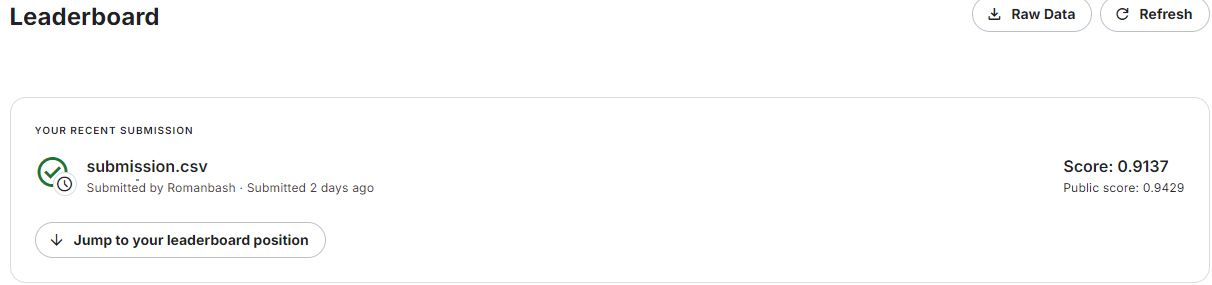

# Conclusion

In this project, we tried Histopathologic Cancer Detection using CNN.
We had more than 200K images, which is excellent for this task. However, the photos themselves were 96* 96 pixels, which makes this task hard for humans and, as we saw in the results, a task that a machine can do successfully.
We achieved a score of more than 90 in Kaggle, and the winners achieved a 100% score.
We tried 3 different approaches to tackle this task.
First, we tried a simple, basic CNN architecture with horizontal and vertical flips. To my surprise, this architecture received a great score of 85% after 5 epochs of training.
Then, we add some layers and complexity to the network, with three convolutional layers, three max-pooling layers, and three dense layers. We also includes dropout layers. We received a 90% validation score, which is a dissent improvement.
Surprisingly, taking a pre-trained SOTA network (EfficientNetB4 model) and finetuning the last layers gave the worst results.
I want to try many more things, but my Google Collab GPU time is out, and I need to stop somewhere. I will name a few:


*   Try to finetune other pre-trained models. Maybe larger ones.
*   Try ensamble of different archtectures.
*   Try other augmentation and preprocessing techniques like width and height shift range, zooming, and rotation.


In conclusion, as we saw from the results of the validation and test for a mission like this—much data with small pictures—we don't need huge networks with thousands of layers. We got great results with a medium network of 3 million parameters and 12 layers.